In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch import nn
import torch
from pytorch_lightning import LightningModule
from torch import nn
from torchinfo import summary
from torchvision import models

import os
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

### Data analysis

In [16]:
SCREEN_WIDTH = 1920
SCREEN_HEIGHT = 1080
GRID_COLS = 2
GRID_ROWS = 2

In [17]:
# load database
df = pd.read_csv('../data_collection_phase/data/only_face.csv')
df.head()


,File Path Face Image,x,y
0,face_image_1.png,1664,624
1,face_image_2.png,1559,434
2,face_image_3.png,1163,715
3,face_image_4.png,377,862
4,face_image_5.png,750,611


1664 624


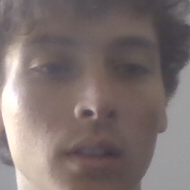

In [48]:
# show first image in df
img_path = df.iloc[0]['File Path Face Image'] # => face_image_1.png
full_path = os.path.join('../data_collection_phase/data/only_face', img_path)
img = Image.open(full_path)
# print point I was looking
print(df.iloc[0]['x'], df.iloc[0]['y'])
img


1559 434


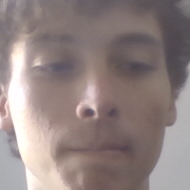

In [49]:
# show first image in df
img_path = df.iloc[1]['File Path Face Image'] # => face_image_1.png
full_path = os.path.join('../data_collection_phase/data/only_face', img_path)
img = Image.open(full_path)
print(df.iloc[1]['x'], df.iloc[1]['y'])
img

1163 715


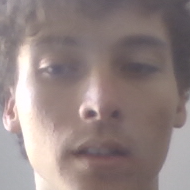

In [50]:
img_path = df.iloc[2]['File Path Face Image'] # => face_image_1.png
full_path = os.path.join('../data_collection_phase/data/only_face', img_path)
img = Image.open(full_path)
print(df.iloc[2]['x'], df.iloc[2]['y'])
img


In [19]:
# screen is 1920x1080. We divide in 2x2 grid.
# each cell is 960x540
# we need to convert the x,y coordinates to the grid cell
df_class = df.copy()
# if x is between 0 and 960 and y is between 0 and 540, the cell is 0
# if x is between 960 and 1920 and y is between 0 and 540, the cell is 1
# if x is between 0 and 960 and y is between 540 and 1080, the cell is 2
# if x is between 960 and 1920 and y is between 540 and 1080, the cell is 3
df_class['cell'] = df_class.apply(lambda row: 0 if row['x'] < 960 and row['y'] < 540 else 1 if row['x'] >= 960 and row['y'] < 540 else 2 if row['x'] < 960 and row['y'] >= 540 else 3, axis=1)
df_class.head()


,File Path Face Image,x,y,cell
0,face_image_1.png,1664,624,3
1,face_image_2.png,1559,434,1
2,face_image_3.png,1163,715,3
3,face_image_4.png,377,862,2
4,face_image_5.png,750,611,2


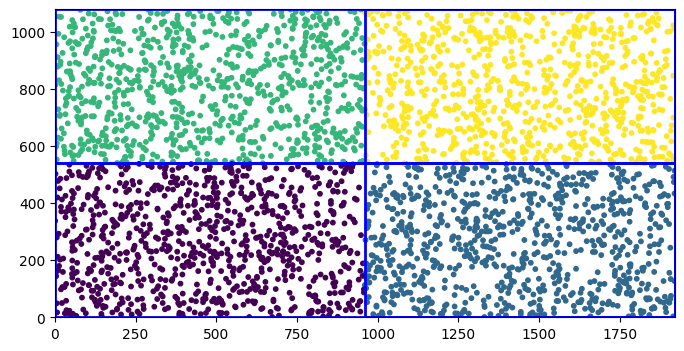

In [20]:
# plot graph simulate the screen 1920x1080
# plot the x,y coordinates in the screen
# plot the cell in the screen

# Create a 1920x1080 plot
plt.figure(figsize=(8, 4))
plt.xlim(0, 1920)
plt.ylim(0, 1080)

# draw square of the cell in the screen
plt.plot([0, 1920, 1920, 0, 0], [0, 0, 540, 540, 0], 'b-', lw=2)
plt.plot([960, 960, 1920, 1920, 960], [0, 540, 540, 0, 0], 'b-', lw=2)
plt.plot([0, 1920, 1920, 0, 0], [540, 540, 1080, 1080, 540], 'b-', lw=2)
plt.plot([960, 960, 1920, 1920, 960], [540, 1080, 1080, 540, 540], 'b-', lw=2)

# plot the x,y coordinates in the screen and if cell is 0, 1, 2, 3, plot the cell in the screen with different color
plt.scatter(df_class['x'], df_class['y'], c=df_class['cell'], label='Eye Position', s=10)

plt.show()


In [21]:
# distnce btw 2 points in 2D space
def distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)


### Keras

In [42]:
all_images = df_class['File Path Face Image'].tolist() # => ['face_image_1.png', 'face_image_2.png' ...]
# add to all_images the full path
all_images = [os.path.join('../data_collection_phase/data/only_face', img) for img in all_images]


In [43]:
# Load and resize images correctly
#images = [np.array(Image.open(path).resize((190, 190))) for path in all_images]
images = [np.expand_dims(np.array(Image.open(path).convert('L').resize((190, 190))), axis=-1) for path in all_images]

images_array = np.array(images, dtype=np.float32) / 255.0  # Ensure dtype is float32

# Convert labels to a 1D array before one-hot encoding
all_cells = np.array(df_class['cell'].tolist())  # Ensure it's 1D
all_cells = to_categorical(all_cells, 4)  # Now it's (num_samples, 4)

# Split train/test
x_train, x_test, y_train, y_test = train_test_split(images_array, all_cells, test_size=0.2, random_state=42)

In [44]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(type(images[0]))
print(images[0].shape)
print("Unique labels in y_train:", np.unique(np.argmax(y_train, axis=1)))

(2748, 190, 190, 1)
(687, 190, 190, 1)
(2748, 4)
(687, 4)
<class 'numpy.ndarray'>
(190, 190, 1)
Unique labels in y_train: [0 1 2 3]


In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Data Augmentation to improve generalization
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
datagen.fit(x_train)

# Compute class weights to handle imbalances
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(np.argmax(y_train, axis=1)),
                                     y=np.argmax(y_train, axis=1))
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Improved Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(190, 190, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

# Increase learning rate for faster convergence
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train with augmentation and class weights
model.fit(datagen.flow(x_train, y_train, batch_size=64),
          validation_data=(x_test, y_test),
          epochs=30,
          class_weight=class_weight_dict)

c:\Users\orlan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


c:\Users\orlan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.2367 - loss: 1.5480 - val_accuracy: 0.2737 - val_loss: 33.0243
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.2359 - loss: 1.4382 - val_accuracy: 0.2737 - val_loss: 78.9746
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.2407 - loss: 2.4911 - val_accuracy: 0.2737 - val_loss: 53.0044
Epoch 4/30
35/43 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.2331 - loss: 1.4352

KeyboardInterrupt: 

In [41]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(190, 190, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 188, 188, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 188, 188, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 92, 92, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 92, 92, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 44, 44, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,768,836 (22.01 MB)

 Trainable params: 5,766,852 (22.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [36]:
# Train
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=100, epochs=10)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.2745 - loss: 1.3926 - val_accuracy: 0.2838 - val_loss: 1.4040
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.2608 - loss: 1.3843 - val_accuracy: 0.2868 - val_loss: 1.4001
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.2544 - loss: 1.3819 - val_accuracy: 0.2766 - val_loss: 1.3946
Epoch 4/10
18/28 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.2687 - loss: 1.3809

KeyboardInterrupt: 

[]

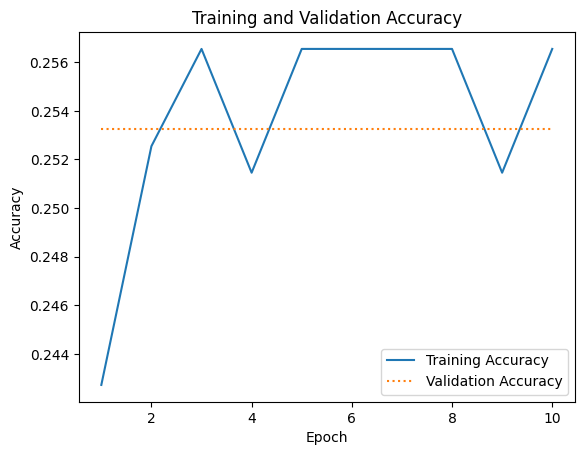

In [13]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

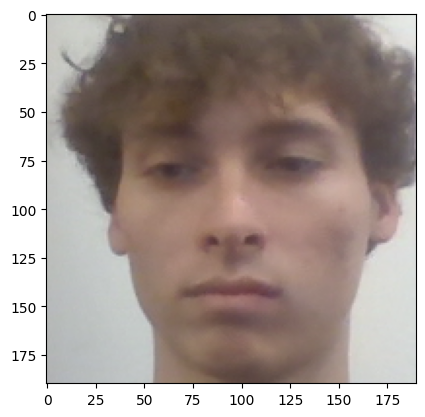

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[[0.25713408 0.24924433 0.2506663  0.24295528]]


In [14]:
# test on one image the prediction and visualize it
image_to_test = x_test[0]
# show image
plt.imshow(image_to_test)
plt.show()
image_to_test = image_to_test.reshape(1, 190, 190, 3)
prediction = model.predict(image_to_test)
print(prediction)

